In [1]:
#import os
import cv2
from matplotlib import pyplot as plt 
import numpy as np
#import random
#import math
#import time

In [2]:
left_1 = cv2.imread('computers_left.png')
right_1 = cv2.imread('computers_right.png')
left_2 = cv2.imread('daft_punk_left.jpg')
right_2 = cv2.imread('daft_punk_right.jpg')
#left_2 = cv2.imread('left.jpg')
#right_2 = cv2.imread('right.jpg')
left1 = cv2.cvtColor(left_1,cv2.COLOR_BGR2RGB)
right1 = cv2.cvtColor(right_1,cv2.COLOR_BGR2RGB)
left2 = cv2.cvtColor(left_2,cv2.COLOR_BGR2RGB)
right2 = cv2.cvtColor(right_2,cv2.COLOR_BGR2RGB)

## 1.1 Feature Matching

In [3]:
def Matches(image1,image2):
    image1 = cv2.cvtColor(image1,cv2.COLOR_BGR2RGB)
    image2 = cv2.cvtColor(image2,cv2.COLOR_BGR2RGB)
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    
    my_SIFT_instance = cv2.SIFT_create()

    imgOut1 = np.copy(image1)
    imgOut2 = np.copy(image2)
    keypoints_1, descriptors_1 = my_SIFT_instance.detectAndCompute(imgOut1,None)
    keypoints_2, descriptors_2 = my_SIFT_instance.detectAndCompute(imgOut2,None)
    
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    feature = cv2.FlannBasedMatcher(index_params,search_params)
    matches = feature.knnMatch(descriptors_1,descriptors_2, k=2) 
    
    good = []
    p1 = []
    p2 = []
    keyp1 = []
    keyp2 = []
    for m,n in matches:
        md = m.distance
        nd = n.distance 
        ratio = md / nd
        tau = 0.8
        if ratio < tau:
            good.append([m])
            p1.append(keypoints_1[m.queryIdx].pt)
            p2.append(keypoints_2[m.trainIdx].pt)
    
    point1_array = np.asarray(p1)  
    point2_array  = np.asarray(p2)
    
    keyp1 = [cv2.KeyPoint(point1_array[i][0], point1_array[i][1], 1)
                    for i in range(point1_array.shape[0])]
    keyp2 = [cv2.KeyPoint(point2_array[i][0], point2_array[i][1], 1)
                    for i in range(point2_array.shape[0])]
       
    img_1 = cv2.drawKeypoints(gray1, keyp1, image1)
    img_2 = cv2.drawKeypoints(gray2, keyp2, image2)
    
    return p1, p2, img_1, img_2

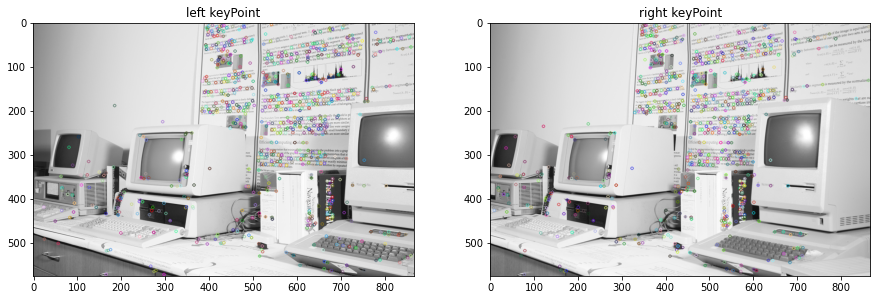

In [4]:
_,_,img_1,img_2 = Matches(left1,right1)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("left keyPoint")
plt.imshow(img_1,cmap = 'gray')

plt.subplot(1,2,2)
plt.title("right keyPoint")
plt.imshow(img_2,cmap = 'gray')

## 1.2 Epipolar Lines Calculation

In [5]:
def drawlines(image1,image2, lines, p1, p2,check):
    c = image1.shape[1]
    r = image1.shape[0]
    Imgcopy1 = np.copy(image1)
    Imgcopy2 = np.copy(image2)
    for r,p1,p2 in zip(lines,p1,p2):
        x0,y0 = map(int, [0, -r[2]/r[1]])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        color = tuple(np.random.randint(0,255,3).tolist())
        image_1 = cv2.line(Imgcopy1, (x0,y0), (x1,y1), color, 1)
        if check == 1:
            image_1 = cv2.circle(Imgcopy1,tuple(p1),5,color, -1)       
    return image_1

In [6]:
def Epipolar_Lines(image1,image2):
    p1 = []
    p2 = []
    p1,p2,_,_ = Matches(image1,image2)
    
    p1 = np.int32(p1)
    p2 = np.int32(p2)
    
    f, mask = cv2.findFundamentalMat(p1, p2, cv2.FM_LMEDS)
    
    p1 = p1[mask.ravel()==1]
    p2 = p2[mask.ravel()==1]
    
    line1 = cv2.computeCorrespondEpilines(p2.reshape(-1,1,2), 2, f)
    line1 = line1.reshape(-1,3)
    Left1 = drawlines(image1,image2,line1,p1,p2,check = 1)
    
    line2 = cv2.computeCorrespondEpilines(p1.reshape(-1,1,2), 1, f)  
    line2 = line2.reshape(-1,3)
    Right1 = drawlines(image2,image1,line2,p2,p1,check = 1)
    
    return Left1, Right1

In [7]:
left_1, right_1 = Epipolar_Lines(left1,right1)

image = np.concatenate((left_1, right_1), axis = 1) 
cv2.namedWindow("image", cv2.WINDOW_NORMAL)
while True:
    cv2.imshow("image",image)
    k = cv2.waitKey(1)
    if k == 27:
        break                                         
cv2.destroyAllWindows()
#plt.figure(figsize=(15,5))
#plt.imshow(image)

#plt.figure(figsize=(15,5))
#plt.subplot(1,2,1)
#plt.title("left")
#plt.imshow(left1)

#plt.subplot(1,2,2)
#plt.title("right")
#plt.imshow(right1)

In [8]:
left_2, right_2 = Epipolar_Lines(left2,right2)
 
image = np.concatenate((left_2,right_2), axis = 1) 
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
cv2.namedWindow("image", cv2.WINDOW_NORMAL)

while True:
    cv2.imshow("image",image)
    k = cv2.waitKey(1)
    if k == 27:
        break                                         
cv2.destroyAllWindows()

#plt.figure(figsize=(15,5))
#plt.title("left")
#plt.imshow(image)

#left_2, right_2 = Epipolar_Lines(right2,left2)
#plt.figure(figsize=(15,5))
#plt.subplot(1,2,1)
#plt.title("left")
#plt.imshow(left1)
#plt.subplot(1,2,2)
#plt.title("right")
#plt.imshow(right1)

## 1.3 Point/Conjugate Epipolar Line Selection

In [9]:
def OnMouseAction(event,x,y,flags,param):

    if event == cv2.EVENT_LBUTTONDOWN:
        points = []
        cv2.destroyAllWindows()
        image1 = param[0]
        image2 = param[1]
        Flag = param[2]
        clickedpoint = (x,y)
        r2 = cv2.circle(image1, clickedpoint, 5, (0, 255, 0), thickness = -1)
        if Flag==0:
            pst1,pst2,_,_, = Matches(image1,image2)
            pst1 = np.int32(pst1)
            pst2 = np.int32(pst2)
            f, mask = cv2.findFundamentalMat(pst1,pst2,cv2.FM_LMEDS)
        
            points.append(clickedpoint)
            points = np.int32(points)
        
            line2 = cv2.computeCorrespondEpilines(points.reshape(-1,1,2), 1, f) 
            line2 = line2.reshape(-1,3)
            r1 = drawlines(image2,image1,line2,pst2,points,check = 0)
            cv2.imshow("select", r2)
            cv2.imshow("out", r1)
            r2 = cv2.cvtColor(r2,cv2.COLOR_BGR2RGB)
            r1 = cv2.cvtColor(r1,cv2.COLOR_BGR2RGB)
            image = np.concatenate((r2, r1), axis = 1) 
            plt.figure(figsize=(15,5))
            plt.imshow(image)
        
        if Flag==1:       
            pst1,pst2,_,_, = Matches(image1,image2)
            pst1 = np.int32(pst1)
            pst2 = np.int32(pst2)
            f, mask = cv2.findFundamentalMat(pst1,pst2,cv2.FM_LMEDS)
        
            points.append(clickedpoint)
            points = np.int32(points)
        
            line2 = cv2.computeCorrespondEpilines(points.reshape(-1,1,2), 1, f) 
            line2 = line2.reshape(-1,3)
            r1 = drawlines(image2,image1,line2,pst2,points,check = 0)
            cv2.imshow("select", r2)
            cv2.imshow("out", r1)
            r2 = cv2.cvtColor(r2,cv2.COLOR_BGR2RGB)
            r1 = cv2.cvtColor(r1,cv2.COLOR_BGR2RGB)
            image = np.concatenate((r1, r2), axis = 1) 
            plt.figure(figsize=(15,5))
            plt.imshow(image)

In [10]:
def EpipolarLineSeclection(img1, img2,Flags):
    img1_cp = np.copy(img1)
    img2_cp = np.copy(img2)
    img1_cp = cv2.cvtColor(img1_cp,cv2.COLOR_BGR2RGB)
    img2_cp = cv2.cvtColor(img2_cp,cv2.COLOR_BGR2RGB)
    while True:
        cv2.imshow("select", img1_cp)
        cv2.setMouseCallback("select",OnMouseAction,[img1_cp, img2_cp,Flags])
        k = cv2.waitKey(1)
        if k == 27:
            break                                         
    cv2.destroyAllWindows()

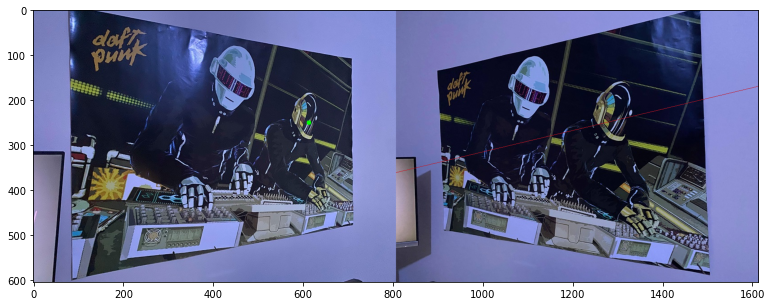

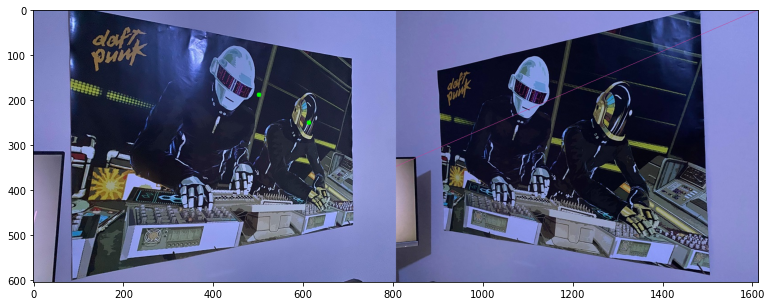

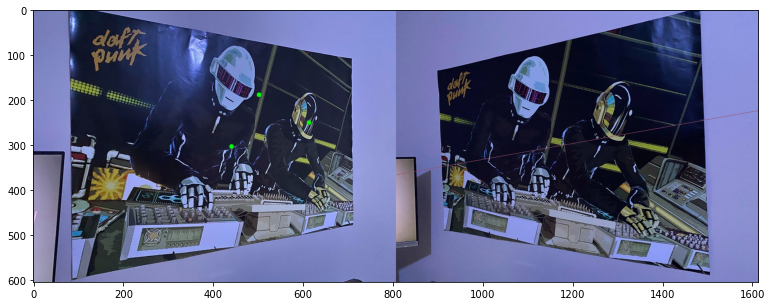

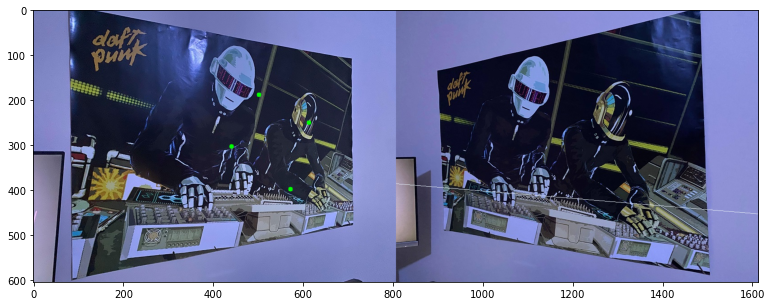

In [11]:
EpipolarLineSeclection(left2, right2 , 0)

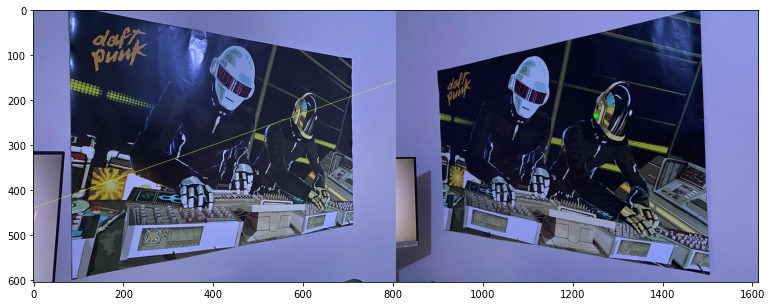

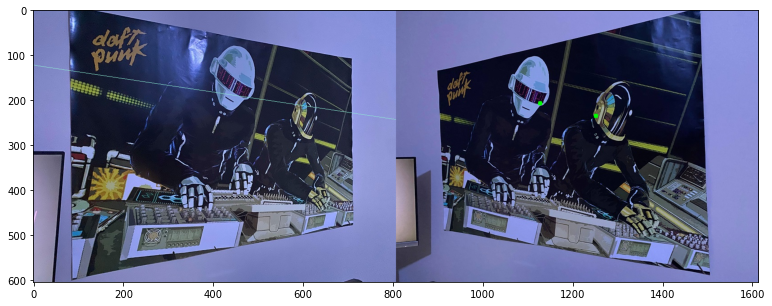

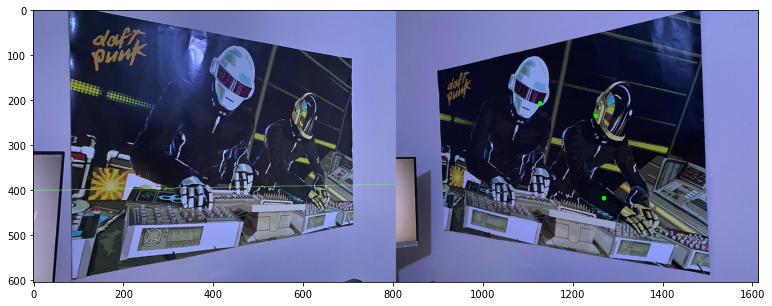

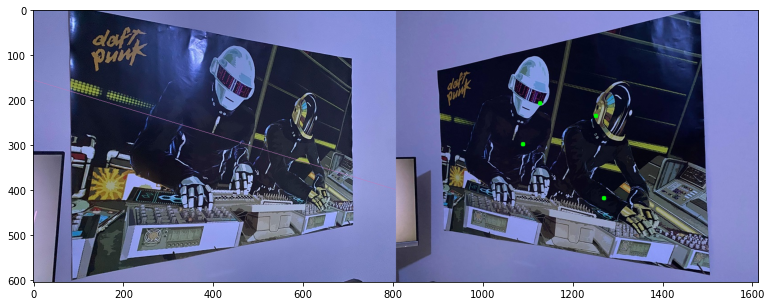

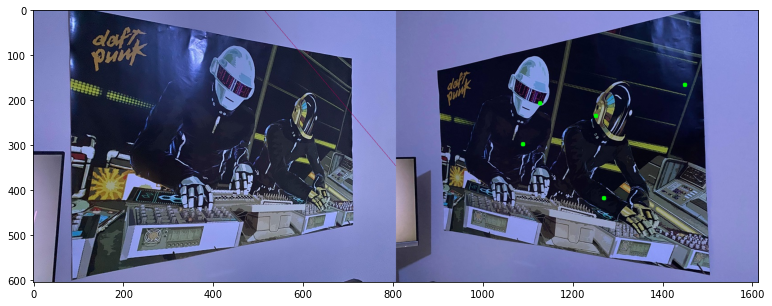

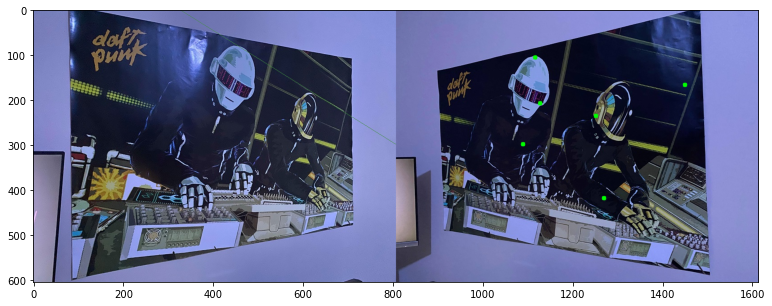

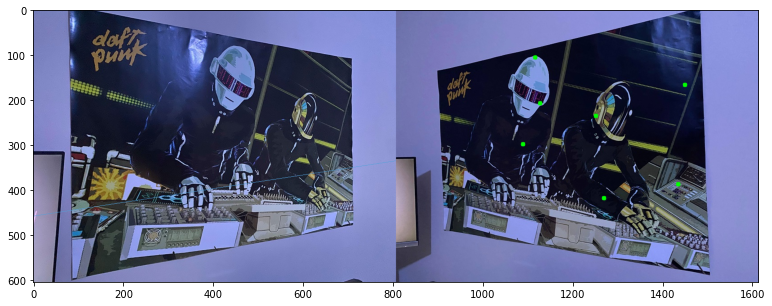

In [12]:
EpipolarLineSeclection(right2,left2,1)